In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

%matplotlib inline

cc = 299792.458 

Planck distance prior from https://arxiv.org/pdf/1808.05724.pdf, table 1, $\Lambda CDM$

In [2]:
#Mean values
mean = np.array( [1.7502, 301.471, 0.02236, 0.9649])

#Standard deviation
std = np.array( [0.0046, 0.09, 0.00015, 0.0043])

#Correlation matrix
corr = np.array( [ [1., 0.46, -0.66, -0.74],
                   [0.46, 1.0, -0.33, -0.35],
                   [-0.66, -0.33, 1., 0.46],
                   [-0.74, -0.35, 0.46, 1.] ])

#Covariance matrix
cov = corr * np.outer(std, std)

#Inverse covariance
icov = np.linalg.inv(cov)

Formulae to obtain $z^*$

$$ 
g_{1}=\frac{0.0738\left(\Omega_{b} h^{2}\right)^{-0.238}}{1+39.5\left(\Omega_{b} h^{2}\right)^{0.763}},
$$
$$
g_{2}=\frac{0.560}{1+21.1\left(\Omega_{b} h^{2}\right)^{1.81}},
$$
$$
z_{*}=1048\left[1+0.00124\left(\Omega_{b} h^{2}\right)^{-0.738}\right]\left[1+g_{1}\left(\Omega_{m} h^{2}\right)^{g_{2}}\right]
$$

In [3]:
def get_g1(omegab, h):
    obh2 = omegab * h *h
    return (0.0738 * obh2 ** -0.238) / (1 + 39.5 * obh2 ** 0.763)

def get_g2(omegab, h):
    obh2 = omegab * h *h
    return (0.560) / (1 + 21.1 * obh2 ** 1.81)

def get_zstar (omegab, omegam, h):
    obh2 = omegab * h * h
    omh2 = omegam * h * h
    g1 = get_g1(omegab, h)
    g2 = get_g2(omegab, h)
    
    return 1048 * (1 + 0.00124 * omh2 ** -0.738) * (1 + g1*omh2**g2)

Formulae to compute Hubble function

In [4]:
def get_zeq (omegam, h, TCMB = 2.7255):
    return 2.5e4 * omegam * h * h * (TCMB/2.7)**-4

def get_EE (zz, omega_r, omega_m, omega_k, omega_de, w0=-1, wa=0):
    zp1 = 1.+zz
    
    ww = w0 + wa * zz/zp1
    
    return np.sqrt(omega_r * zp1**4 +\
                   omega_m * zp1**3  +\
                   omega_k * zp1**2+\
                   omega_de * zp1**(3*(1+ww)) )

def get_HH (zz, h, omega_r, omega_m, omega_k, omega_de, w0=-1, wa=0):
    
    return h*100*get_EE(zz, omega_r, omega_m, omega_k, omega_de, w0=w0, wa=wa)

Formulae to compute angular diameter distance $D_A(z)$

$$
D_{\mathrm{A}}=\frac{c}{(1+z) H_{0} \sqrt{\left|\Omega_{k}\right|}} \operatorname{sinn}\left[\left|\Omega_{k}\right|^{1 / 2} \int_{0}^{z} \frac{d z^{\prime}}{E\left(z^{\prime}\right)}\right]
$$

where $\mathrm{sinn}(x) \equiv \sin(x), x, \sinh(x)$ for $\Omega_k <0$, $\Omega_k=0$, $\Omega_k>0$.

In [5]:
def get_DA(zz, h, omega_r, omega_m, omega_k, omega_de, w0=-1, wa=0):
    
    integrand = lambda _zz : 1./get_EE(_zz, omega_r, omega_m, omega_k, omega_de, w0=w0, wa=wa)
    
    II = quad(integrand, 0, zz)[0]
   
    if (omega_k<0):
        II = np.sin( np.sqrt( np.abs(omega_k)) * II) / np.sqrt( np.abs(omega_k))
    elif (omega_k>0):
        II = np.sinh(np.sqrt( np.abs(omega_k)) * II) / np.sqrt( np.abs(omega_k))
    
    return cc/( (1+zz) * 100 * h )  * II

Formulae to compute sound horizon $r_s(z)$

$$
r_{s}(z)=\frac{c}{H_{0}} \int_{0}^{1 /(1+z)} \frac{d a}{a^{2} E(a) \sqrt{3\left(1+\frac{3 \Omega_{b} h^{2}}{4 \Omega_{\gamma} h^{2}} a\right)}}
$$

$$
\frac{3}{4 \Omega_{\gamma} h^{2}}=31500\left(T_{\mathrm{CMB}} / 2.7 K\right)^{4}, \quad T_{\mathrm{CMB}}=2.7255 K
$$

I'm not sure Eq. 3 in the paper is right. Since $\Omega_{\gamma}$ is at the denominator, I would have expected $\left(T_{\mathrm{CMB}} / 2.7 K\right)^{4}$ instead. I changed it

In [6]:
def rs_integrand(aa, h, omega_b, omega_r, omega_m, omega_k, omega_de, w0=-1, wa=0, TCMB=2.7255):
    zz = 1./aa-1
    EE =  get_EE(zz, omega_r, omega_m, omega_k, omega_de, w0=w0, wa=wa)
    omega_g = 2.469e-5
    factor = 31500. * (TCMB/2.7)**4 * omega_b * h **2
    
    return 1./( aa**2 * EE * np.sqrt( (1+factor*aa) ) )

def get_rs(zz, h, omega_b, omega_r, omega_m, omega_k, omega_de, w0=-1, wa=0, TCMB=2.7255):
    
    integrand = lambda aa : rs_integrand(aa, h, omega_b, omega_r, omega_m, omega_k, omega_de, w0, wa, TCMB)    
    return cc/( np.sqrt(3) * 100 * h) * quad(integrand, 0, 1./(1+zz) )[0]


Formula to compute the sound horizon $l_A(z)$

$$
l_{\mathrm{A}}=\left(1+z_{*}\right) \frac{\pi D_{\mathrm{A}}\left(z_{*}\right)}{r_{s}\left(z_{*}\right)}
$$

In [7]:
def get_ell_A(h, omega_b, omega_r, omega_m, omega_k, omega_de, w0=-1, wa=0, TCMB=2.7255):
    zstar = get_zstar(omega_b, omega_m, h)
    DA = get_DA(zstar, h, omega_r, omega_m, omega_k, omega_de, w0, wa)
    rs = get_rs(zstar, h, omega_b, omega_r, omega_m, omega_k, omega_de, w0, wa, TCMB)
    return (1+zstar)*np.pi*DA/rs

Formula to compute the shift parameter $R(z)$

$$
R\left(z_{*}\right) \equiv \frac{\left(1+z_{*}\right) D_{\mathrm{A}}\left(z_{*}\right) \sqrt{\Omega_{m} H_{0}^{2}}}{c}
$$

In [8]:
def get_RR(h, omega_b, omega_r, omega_m, omega_k, omega_de, w0=-1, wa=0):
    zstar = get_zstar(omega_b, omega_m, hh)
    DA = get_DA(zstar, h, omega_r, omega_m, omega_k, omega_de, w0, wa)
    
    return (1+zstar) * DA * np.sqrt(omega_m * (100 * hh)**2 )/cc

The model to reproduce CMB distance priors

- Assume flatness and cosmological constant as dark energy:
    $$\Omega_k = 0$$
    $$
       \Omega_{r}=\frac{\Omega_{m}}{1+z_{\mathrm{eq}}}, \quad z_{\mathrm{eq}}=2.5 \times 10^{4} \Omega_{m} h^{2}\left(T_{C M B} / 2.7 \mathrm{K}\right)^{-4}
    $$
    $$
        \Omega_{\Lambda} = 1-\Omega_M-\Omega_R \\
        w_0 = -1\\
        w_a = 0        
    $$

In [9]:
def get_model(theta):
    
    h, omega_m, omega_b_h2, ns = theta
    zeq = get_zeq (omega_m, h)
    
    omega_b = omega_b_h2/(h**2)
    omega_r = omega_m/(1+zeq)
    omega_k = 0
    omega_de = 1-omega_m-omega_r
    
    zstar = get_zstar(omega_b, omega_m, h)
    DA = get_DA(zstar, h, omega_r, omega_m, omega_k, omega_de)
    rs = get_rs(zstar, h, omega_b, omega_r, omega_m, omega_k, omega_de)
    
    RR = (1+zstar) * DA * np.sqrt(omega_m * (100 * h)**2 )/cc
    la = (1+zstar)*np.pi*DA/rs
    
    return np.array([RR, la, omega_b_h2, ns])



    

Assume flat prior on a reasonable large range

In [10]:
def log_prior(theta):
    hh, omega_m, omega_b, ns = theta

    if 0.5 < hh < 0.9 and 0.1 < omega_m < 0.5 and 0.005 < omega_b < 0.05 and 0.8 < ns < 1.1:
        return 0.0
    return -np.inf

Set a gaussian likelihood

In [11]:
def lnprob(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    diff = mean-get_model(theta)
    
    return -0.5 * np.dot(diff, np.dot(icov, diff)) + lp

Run the chains and plot

In [12]:
import emcee as em

nwalkers, nstep = 64, 2000
npar = 4
pos = np.array([0.7, 0.3, 0.02, 1]) + 1e-4 * np.random.randn(nwalkers, npar)
nwalkers, ndim = pos.shape

sampler = em.EnsembleSampler(nwalkers, ndim, lnprob)
_ = sampler.run_mcmc(pos, nstep, progress=True)

100%|██████████| 2000/2000 [03:19<00:00, 10.04it/s]


Reference values:
    
- $h = 0.6727 \pm 0.0060 $ 
- $\Omega_M = 0.3166 \pm 0.0084 $
- $\Omega_b h^2 = 0.02236 \pm 0.00015 $
- $n_s = 0.9649 \pm  0.0044 $

In [13]:
fig, axes = plt.subplots(4, figsize=(13, 7), sharex=True)
samples = sampler.get_chain()

labels = ["$h$", r"$\Omega_M$", r"$\Omega_b h^2 $", r"$n_s$"]

hvalues = [0.6727, 0.3166, 0.02236, 0.9649]
hvalues_err = [0.006, 0.0084, 0.00015, 0.0044]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

    ax.axhline(hvalues[i], color="r", ls="--")
    ax.axhline(hvalues[i]-hvalues_err[i], color="r", ls="--")
    ax.axhline(hvalues[i]+hvalues_err[i], color="r", ls="--")
    ax.fill_between(range(len(samples)), hvalues[i]-hvalues_err[i], hvalues[i]+hvalues_err[i], color="r", alpha=0.3, zorder=1000)

axes[-1].set_xlabel("step number");


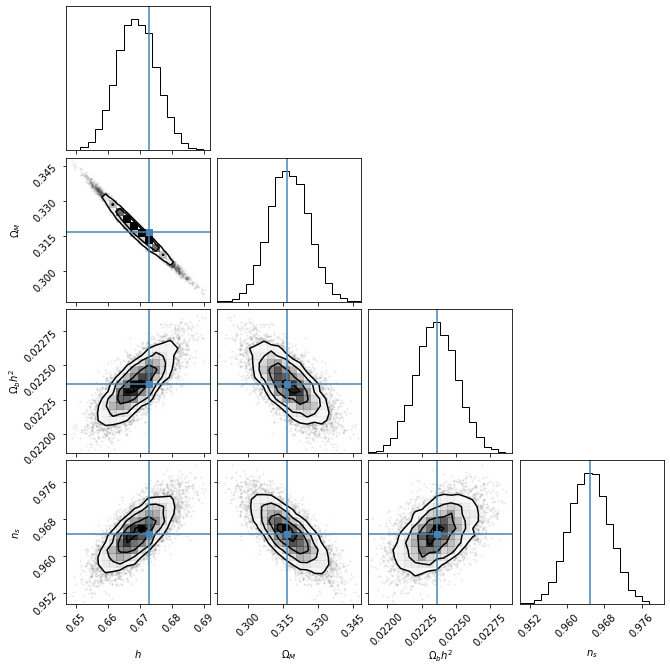

In [14]:
import corner

flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=hvalues
);